In [1]:
# ML_in_Finance-Autoencoders
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Introduction

The purpose of this notebook is to first review PCA for yield curve dimension reduction. Linear autoencoders are then compared with PCA. Finally we evaluate deep autoencoders for yield curve compression.

# PCA
Principal component analysis requires finding the weights which maximize the maximum weighted variance of the data $Y$: 
$$\max_{w:||w||=1}Var(w^TY) = \max_{w:||w||=1}w^TVar(Y)w$$

Setting $w=v$, with $v$ the eigenvector corresponding to the largest eigenvalue $\lambda$ of $C:=Var(Y)$ will yield an orthogonal projection which is an optimal solution. From the eigenvalue problem, we can obtain the eigenvalues of $V$:

$$C v=\lambda v$$
$$(C-\lambda I)v=0$$
$$ |C-\lambda I|=0$$

Plugging the eigenvalues into second equation above gives the eigenvectors. The result can be written as:

$$\Lambda=V^TCV,$$

where $\Lambda$ is the diagonal matrix of descending eigenvalues and $P$ is the corresponding orthornormal matrix of eigenvectors. Rearanging gives the spectral decomposition of the covariance matrix.

$$C=P\Lambda P^T$$.

The transformation of Y onto the orthonormal basis spanned by the columns of $P$ is:
$$X=P^TY$$

# Libs & Defs

In [2]:
from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.decomposition import PCA

Using TensorFlow backend.
/Users/Dez/anaconda3/envs/malfoy/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%matplotlib inline

In [4]:
# Linear Autoencoder
def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input_layer = Input(shape=(y.shape[1],))
    
    # the encoder layer transforms the input into a representation of size `dimension`
    encoder = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    
    # the decoder layer transforms the encoded representation back to the original size
    decoder = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoder)
    
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    
    # the autoencoder aims to map the input back onto itself, via
    # a lower-dimensionality representation in the hidden layer
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [5]:
!ls

1d-CNN-multi.ipynb
Copy_of_ML_in_Finance_RNNs_Bitcoin(1).ipynb
Copy_of_ML_in_Finance_RNNs_Bitcoin.ipynb
ML_in_Finance-1D-CNNs.ipynb
ML_in_Finance-2D-CNNs.ipynb
ML_in_Finance-Autoencoders.ipynb
ML_in_Finance-RNNs-Bitcoin-Copy1.ipynb
ML_in_Finance-RNNs-Bitcoin.ipynb
ML_in_Finance-RNNs-HFT.ipynb
README.md
__pycache__
alphaRNN.py
alphatRNN.py


# Load Dataset

In [6]:
df = pd.read_csv('../data/yield_curve.csv', sep=',')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

df.set_index('Date', drop=True, inplace=True)

df.index.names = [None]

df.drop('Index', axis=1, inplace=True)

n_obs = len(df)

##### Uncomment the `elif (...)` line to perform PCA on the daily yield changes $\Delta Y_0$:

In [7]:
if len(df) == n_obs - 1: print('differences already taken')
#elif len(df) == n_obs: df, dt = df.diff(1).iloc[1:], df.diff(1).iloc[1:].transpose() 

In [8]:
df.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


# Visualizing the Dataset

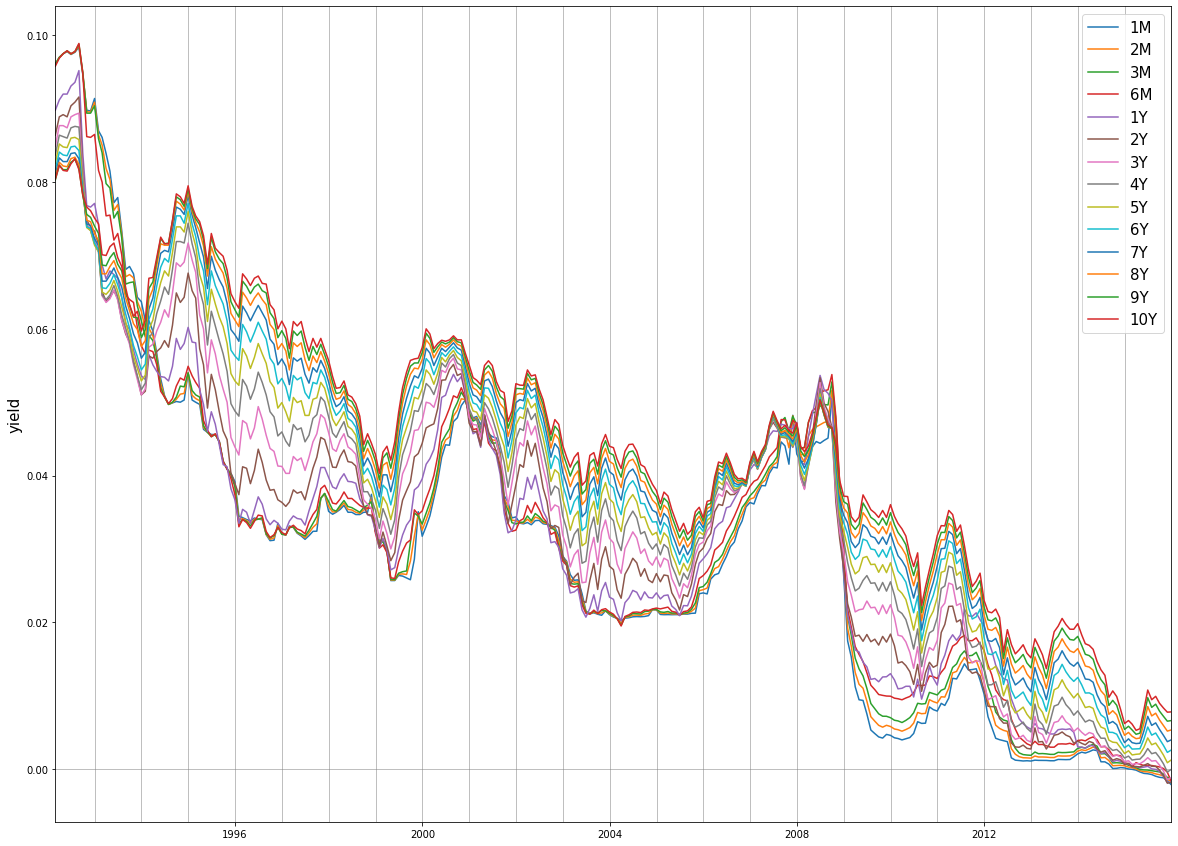

In [9]:
plt.figure(figsize=(20,15))

plt.plot(df.index, df)
plt.xlim(df.index.min(), df.index.max())
plt.ylabel('yield', fontsize=15)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
plt.legend(df.columns, fontsize=15)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=datetime(i, 1, 1), c="grey", linewidth=0.5, zorder=0)

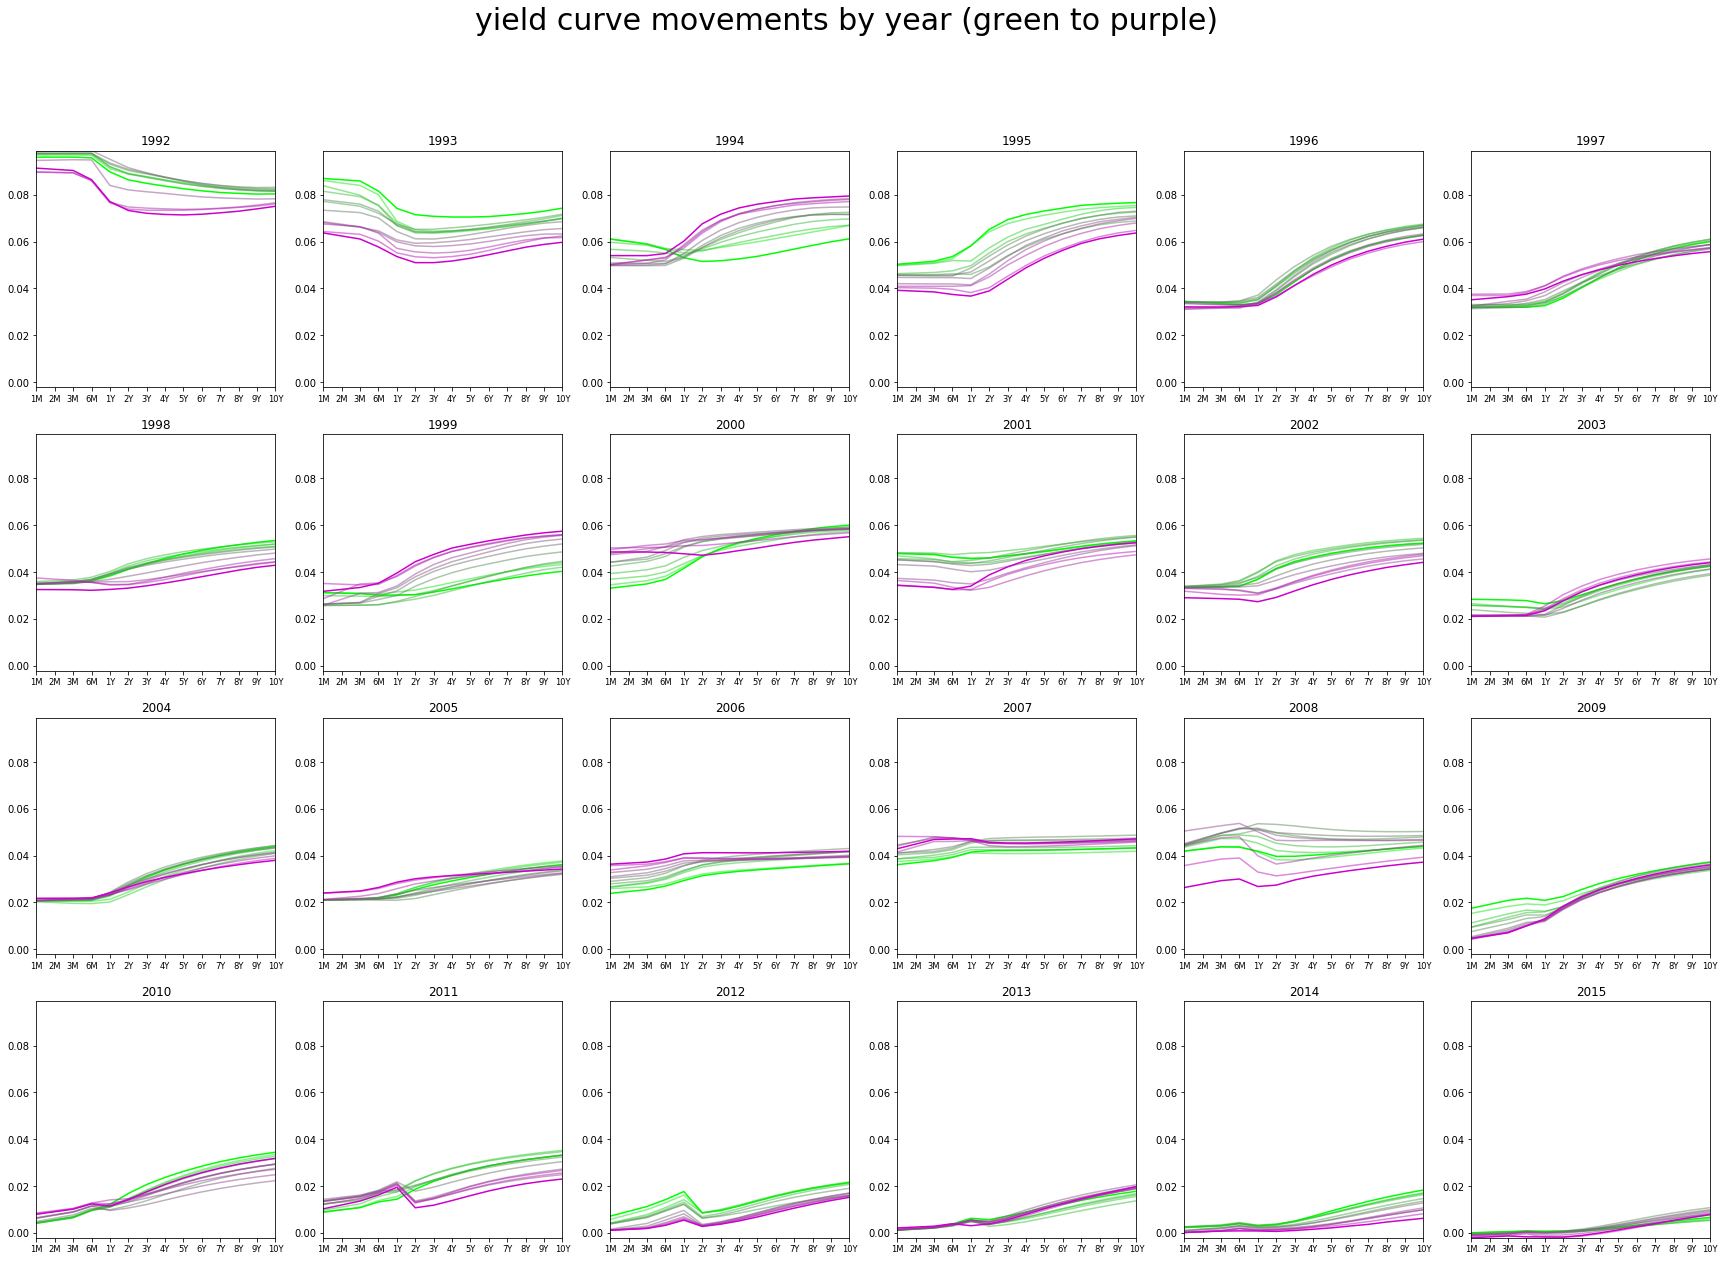

In [10]:
cols = 6
num_years = df.index.max().year - df.index.min().year
rows = int(np.ceil(num_years/cols))

# each line is a yield curve at a given time; each year begins green and ends purple
plt.figure(figsize=(30, (30/cols)*rows))
plt.suptitle('yield curve movements by year (green to purple)', fontsize=30)

colnum = 0
rownum = 0
for year in range(df.index.min().year, df.index.max().year+1):
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    plt.subplot2grid((rows, cols), (rownum, colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(df.columns)-1)
    plt.ylim(np.min(df.values), np.max(df.values))
    plt.xticks(range(len(df.columns)), df.columns, size='small')
    
    year_curves = df.loc[year_start:year_end].values    
    gradient = np.linspace([0, 1, 0, 1], [0.8, 0, 0.8, 1], year_curves.shape[0])
    gradient[1:-1, -1] = 0.5
    
    for yield_curve, colour in zip(year_curves, gradient):
        plt.plot(yield_curve, c=colour)

    
    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

# Projection onto Principal Components

In [11]:
# calculate the first three PCs (Eigenvectors & Eigenvalues of the covariance matrix)
pca_model = PCA(n_components=3, copy=True, whiten=False)
pca_model.fit(df)

# project the dataset onto the principal components
df_pca = pd.DataFrame(pca_model.transform(df), index=df.index)

df_pca.columns = ['PC1', 'PC2', 'PC3']

# transform the projections back into the input space
df_pca_reconstructed = pd.DataFrame(pca_model.inverse_transform(df_pca), index=df.index, columns=df.columns)

In [12]:
df_pca.head()

,PC1,PC2,PC3
1992-02-29,0.189681,0.031657,-0.002092
1992-03-31,0.196655,0.029239,-0.003471
1992-04-30,0.196720,0.031033,-0.003950
1992-05-31,0.196820,0.031674,-0.003434
1992-06-30,0.199527,0.029321,-0.005054


## Evaluate and plot the reconstruction error

In [13]:
# the reconstruction error is the orthogonal distance between each point and the PCA subspace
pca_rec_errs = np.sqrt(np.sum((df_pca_recon - df)**2, axis=1))
pca_rec_errs.index = df.index
pca_rec_errs.head()

NameError: name 'df_pca_recon' is not defined

In [ ]:
plt.figure(figsize=(20,15))

plt.plot(df.index, dpca_rec_errs)
plt.xlim(df.index.min(), df.index.max())
plt.ylim(0, df_pca_rec_errs.max()*1.05)
plt.ylabel('reconstruction error', size=20)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

### Evaluate the amount of variance explained by each component

In [ ]:
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

### Plot the loading vectors

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.components_.shape[0]))

plt.plot(np.transpose(pca_model.components_[0]), label='PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label='PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label='PC 3')
plt.xticks(range(len(df.columns)), df.columns, size='small')

plt.legend() #'upper right')
None›

# Linear Autoencoders

### Fit the linear auto-encoder

In [ ]:
ae_model = LinearAE(df.values, 3, regularization=0, epochs=300) #¢# epochs=300
(w1, b1, w2, b2) = ae_model.get_weights()

### Extract the first singular vectors of the decoder weight matrix
The left singular vectors approximate the PCA loading vectors (up to a sign)

In [ ]:
# PCA by applying SVD to linear autoencoder weights
(ae_decoder_svd, _, _) = np.linalg.svd(w2.T, full_matrices=False)

In [ ]:
df_ae_reconstructed = ae_model.predict(df)
#ae_reconstructed = ae_model.predict((df.values-mu)/std + mu.reshape(1,14))*std

In [ ]:
plt.figure(figsize=(25,20))
plt.title('reconstructed values vs original values [AE in red; PCA in yellow; ideal reconstruction in black]'
         , fontsize='20')
plt.scatter(df_ae_reconstructed, df, marker='.', c='red') # ae recon vs original data
plt.scatter(df_pca_reconstructed, df, marker='.', c='yellow') # pca preimage vs original data
plt.plot(np.linspace(0,0.1,100),np.linspace(0,0.1,100),c='black') # y = x

In [ ]:
mu = np.mean(df.values, axis=0)
ae_svd_projections = np.array(df.values-mu) @ ae_decoder_svd

In [ ]:
sns.heatmap(w2)

In [ ]:
df_ae = pd.DataFrame(ae_svd_projections, index=df.index)

Diagonalize the sample covariance matrix with the m-loading vectors:
$$\text{P}_m^T \text{Y}_0 \text{Y}_0^T \text{P}_m$$

The sample covariance matrix is given by C.

In [ ]:
C = np.dot((df-mu).T, df-mu)
ax = sns.heatmap(C)

The total variance is given by the sum of the diagonal elements of the covariance matrix

In [ ]:
total_variance = np.sum(np.diag(C))
print('total variance:', total_variance)

### Compare the transformed sample covariances
Begin with PCA

In [ ]:
Lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

In [ ]:
ax = sns.heatmap(Lambda_from_pca, annot=True)

Show the explained variances by each component (check with above)

In [ ]:
print(100 * np.diag(Lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(Lambda_from_pca)) / total_variance))

Now perform the transformation of the covariance matrix using the decoder weights. Note that the matrix $\Lambda$ is no longer diagonal.

In [ ]:
Lambda_from_decoder_weights = w2 @ C @ w2.T
np.matmul(w2,np.matmul(C, w2.T))

In [ ]:
ax = sns.heatmap(Lambda_from_decoder_weights, annot=True)
plt.show()

Finally, perform the transformation of the covariance matrix using the left singular vectors of the decoder weights. Note that the matrix $\Lambda$ is diagonal.

In [ ]:
Lambda_from_decoder_svd = ae_decoder_svd.T @ C @ ae_decoder_svd

In [ ]:
ax = sns.heatmap(Lambda_from_decoder_svd, annot=True)
plt.show()

Show the explained variances by each diagonal component and compare with PCA.

In [ ]:
print(100*np.diag(Lambda_from_decoder_svd) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(Lambda_from_decoder_svd)) / total_variance))

## Visualize the data projected onto the principal components
First show the data on the principal components obtained by PCA. Then show the data using the left singular vectors from the decoder weight matrix.

In [ ]:
# plot the result
merged_years = 1
pc1 = 0
pc2 = 1
fig = plt.figure(figsize=(16,12))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], c = [d.year for d in df_pca.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]))


Now show the data using the left singular vectors from the decoder weight matrix. Note that the sign of the first principal component has been changed for ease of comparison.

In [ ]:
# plot the result
merged_years = 1
pc1 = 0
pc2 = 1
fig = plt.figure(figsize=(16, 12))
plt.title('Projection on {0}. and {1}. PC'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey", linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey", linewidth=1.0,zorder=0)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], c=[d.year for d in df_ae.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]))

    #plt.annotate('{0}'.format(year), xy=df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), xytext=(df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]))

None

### Plot the reconstruction error of the linear autoencoder

In [ ]:
y_hat_l=ae.predict(df)
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(y_hat_l-df))
plt.xlim(df.index.min(), df.index.max())
# plt.ylim(0, 0.1)
plt.ylim(-0.008, 0.008)
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(pd.datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

### Deep Autoencoders

In [ ]:
# Deep Autoencoder
def DeepAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(np.int(2*dimension), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    encoded2 = Dense(dimension, activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded1)
    decoded1 = Dense(np.int(y.shape[1]/2), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded2)
    decoded2 = Dense(y.shape[1], activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(decoded1)
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [ ]:
deepAE_model = DeepAE(df, 3, regularization=0, epochs=5)

### Plot the reconstruction error of the linear autoencoder by variable

In [ ]:
y_hat_d=deepAE_model.predict(df)
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(y_hat_d-df))
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
#plt.ylim(-0.008, 0.008)
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(pd.datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)